In [1]:
import sympy as sp
import numpy as np
import pyLBM

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# The heat equation in 2D

$$
\renewcommand{\DdQq}[2]{{\mathrm D}_{#1}{\mathrm Q}_{#2}}
\renewcommand{\drondt}{\partial_t}
\renewcommand{\drondx}{\partial_x}
\renewcommand{\drondtt}{\partial_{tt}}
\renewcommand{\drondxx}{\partial_{xx}}
\renewcommand{\drondyy}{\partial_{yy}}
\renewcommand{\dx}{\Delta x}
\renewcommand{\dt}{\Delta t}
\renewcommand{\grandO}{{\mathcal O}}
\renewcommand{\density}[2]{\,f_{#1}^{#2}}
\renewcommand{\fk}[1]{\density{#1}{\vphantom{\star}}}
\renewcommand{\fks}[1]{\density{#1}{\star}}
\renewcommand{\moment}[2]{\,m_{#1}^{#2}}
\renewcommand{\mk}[1]{\moment{#1}{\vphantom{\star}}}
\renewcommand{\mke}[1]{\moment{#1}{e}}
\renewcommand{\mks}[1]{\moment{#1}{\star}}
$$

In this tutorial, we test a very classical lattice Boltzmann scheme $\DdQq{2}{5}$ on the heat equation.

The problem reads
$$
\begin{gathered} \drondt u = \mu (\drondxx+\drondyy) u, \quad t>0, \quad (x, y)\in(0,1)^2,\\ u(0) = u(1) = 0, \end{gathered}
$$

where $\mu$ is a constant scalar.

## The scheme $\DdQq{2}{5}$

The numerical simulation of this equation by a lattice Boltzmann scheme consists in the approximatation of the solution on discret points of $(0,1)^2$ at discret instants.

To simulate this system of equations, we use the $\DdQq{2}{5}$ scheme given by

* five velocities $v_0=(0,0)$, $v_1=(1,0)$, $v_2=(0,1)$, $v_3=(-1,0)$, and $v_4=(0,-1)$ with associated distribution functions $\fk{i}$, $0\leq i\leq 4$,
* a space step $\dx$ and a time step $\dt$, the ration $\lambda=\dx/\dt$ is called the scheme velocity,
* five moments
  $$ \mk{0}=\sum_{i=0}^{4} \fk{i}, \quad \mk{1}= \sum_{i=0}^{4} v_{ix} \fk{i}, \quad \mk{2}= \sum_{i=0}^{4} v_{iy} \fk{i}, \quad \mk{3}= \frac{1}{2} \sum_{i=0}^{5} (v_{ix}^2+v_{iy}^2) \fk{i}, \quad \mk{4}= \frac{1}{2} \sum_{i=0}^{5} (v_{ix}^2-v_{iy}^2) \fk{i},$$
  
  and their equilibrium values $\mke{k}$, $0\leq k\leq 4$.
* two relaxation parameters $s_1$ and $s_2$ lying in $[0,2]$ ($s_1$ for the odd moments and $s_2$ for the odd ones).

In order to use the formalism of the package pyLBM, we introduce the five polynomials that define the moments: $P_0 = 1$, $P_1=X$, $P_2=Y$, $P_3=(X^2+Y^2)/2$, and $P_4=(X^2-Y^2)/2$, such that
$$ 
\mk{k} = \sum_{i=0}^4 P_k(v_{ix}, v_{iy}) \fk{i}.
$$

The transformation $(\fk{0}, \fk{1}, \fk{2}, \fk{3}, \fk{4})\mapsto(\mk{0},\mk{1}, \mk{2}, \mk{3}, \mk{4})$ is invertible if, and only if, the polynomials $(P_0,P_1,P_2,P_3,P_4)$ is a free set over the stencil of velocities.

The lattice Boltzmann method consists to compute the distribution functions $\fk{i}$, $0\leq i\leq 4$ in each point of the lattice $x$ and at each time $t^n=n\dt$.
A step of the scheme can be read as a splitting between the relaxation phase and the transport phase:

* relaxation: 
$$
    \begin{aligned}\mks{1}(t,x,y)&=(1-s_1)\mk{1}(t,x,y)+s_1\mke{1}(t,x,y),\\ \mks{2}(t,x,y)&=(1-s_1)\mk{2}(t,x,y)+s_1\mke{2}(t,x,y),\\ \mks{3}(t,x,y)&=(1-s_2)\mk{3}(t,x,y)+s_2\mke{3}(t,x,y),\\ \mks{4}(t,x,y)&=(1-s_2)\mk{4}(t,x,y)+s_2\mke{4}(t,x,y).\end{aligned}
$$

* m2f:
$$
    \begin{aligned}\fks{0}(t,x,y)&\;=\mk{0}(t,x,y)-2\mks{3}(t,x,y), \\ \fks{1}(t,x,y)&\;=\tfrac{1}{2}(\phantom{-}\mks{1}(t,x,y)+\mks{3}(t,x,y)+\mks{4}(t,x,y)), \\ \fks{2}(t,x,y)&\;=\tfrac{1}{2}(\phantom{-}\mks{2}(t,x,y)+\mks{3}(t,x,y)-\mks{4}(t,x,y)), \\ \fks{3}(t,x,y)&\;=\tfrac{1}{2}(-\mks{1}(t,x,y)+\mks{3}(t,x,y)+\mks{4}(t,x,y)), \\ \fks{4}(t,x,y)&\;=\tfrac{1}{2}(-\mks{2}(t,x,y)+\mks{3}(t,x,y)-\mks{4}(t,x,y)).\end{aligned}
$$

* transport: 
$$
    \begin{aligned} \fk{0}(t+\dt, x,y)&\;=\fks{0}(t,x,y), \\ \fk{1}(t+\dt, x,y)&\;=\fks{1}(t,x-\dx,y), \\ \fk{2}(t+\dt, x,y)&\;=\fks{2}(t,x,y-\dx), \\ \fk{3}(t+\dt, x,y)&\;=\fks{3}(t,x+\dx,y), \\ \fk{4}(t+\dt, x,y)&\;=\fks{4}(t,x,y+\dx). \end{aligned}
$$

* f2m:
$$
    \begin{aligned}\mk{0}(t+\dt,x,y)&\;=\fk{0}(t+\dt,x,y)+\fk{1}(t+\dt,x,y)+\fk{2}(t+\dt,x,y)\\&\;\phantom{=}+\fk{3}(t+\dt,x,y)+\fk{4}(t+\dt,x,y), \\ \mk{1}(t+\dt,x,y)&\;=\fk{1}(t+\dt,x,y)-\fk{3}(t+\dt,x,y), \\ \mk{2}(t+\dt,x,y)&\;=\fk{2}(t+\dt,x,y)-\fk{4}(t+\dt,x,y), \\ \mk{3}(t+\dt,x,y)&\;=\tfrac{1}{2}(\fk{1}(t+\dt,x,y)+\fk{2}(t+\dt,x,y)+\fk{3}(t+\dt,x,y)+\fk{4}(t+\dt,x,y)), \\ \mk{4}(t+\dt,x,y)&\;=\tfrac{1}{2}(\fk{1}(t+\dt,x,y)-\fk{2}(t+\dt,x,y)+\fk{3}(t+\dt,x,y)-\fk{4}(t+\dt,x,y)).\end{aligned}
$$

The moment of order $0$, $\mk{0}$, being conserved during the relaxation phase, 
a diffusive scaling $\dt=\dx^2$, yields to the following equivalent equation
$$
\drondt\mk{0} = \bigl(\tfrac{1}{s_1}-\tfrac{1}{2}\bigr) \bigl(\drondxx(\mke{3}+\mke{4})+\drondyy(\mke{3}-\mke{4})\bigr) + \grandO(\dx^2),
$$

if $\mke{1}=0$.
In order to be consistent with the heat equation, the following choice is done:
$$
\mke{3}=\tfrac{1}{2}u, \qquad \mke{4}=0, \qquad s_1 = \frac{2}{1+4\mu}, \qquad s_2=1.
$$


In [2]:
##########################################################
#                 physical parameters                    #
##########################################################
xmin, xmax = 0., 1. # bounds of the domain
ymin, ymax = 0., 1. # bounds of the domain
mu = 1.             # Fourier coefficient
Tf = .25            # final time
k, l = 1, 1         # number of the wave

##########################################################
#                   exact solution                       #
##########################################################
def solution(x, y, t, k, l):
    return np.sin(np.pi*k*x)*np.sin(np.pi*l*y)*np.exp(-np.pi**2*(k**2+l**2)*mu*t)

##########################################################
#              parameters of the simulation              #
##########################################################
N = 128              # number of points in space
dx = (xmax-xmin)/N   # spatial step
la = 1./dx           # diffusive scaling
s1 = 2./(1+4*mu)     # relaxation parameter for m[1] and m[2]
s2 = 1.              # relaxation parameter for m[3] and m[4]

## Using pyLBM

pyLBM uses Python dictionary to describe the simulation. In the following, we will build this dictionary step by step.

### The geometry

In pyLBM, the geometry is defined by a box and a label for the boundaries. We define here a square $(0, 1)^2$.

Geometry informations
	 spatial dimension: 2
	 bounds of the box: 
[[ 0.  1.]
 [ 0.  1.]]



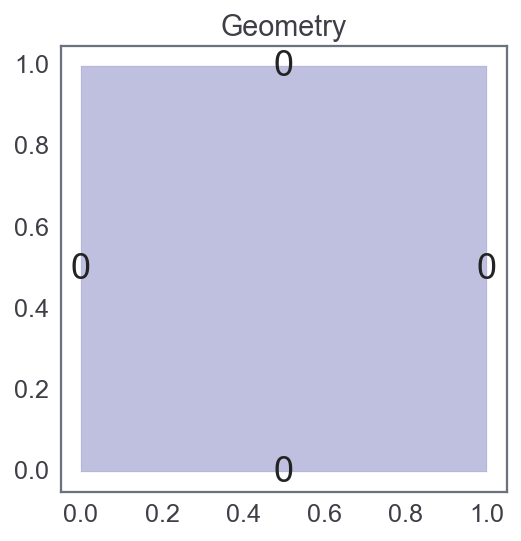

In [3]:
dico_geom = {
    'box': {
        'x': [xmin, xmax], 
        'y': [ymin, ymax], 
        'label': 0,
    },
}
geom = pyLBM.Geometry(dico_geom)
print(geom)
geom.visualize(viewlabel=True, alpha=.25)

### The stencil

pyLBM provides a class stencil that is used to define the discret velocities of the scheme. In this example, the stencil is composed by the velocities $v_0=(0,0)$, $v_1=(1,0)$, $v_2=(-1,0)$, $v_3=(0,1)$, and $v_4=(0,-1)$ numbered by $[0,1,2,3,4]$.

Stencil informations
	 * spatial dimension: 2
	 * maximal velocity in each direction: [1 1]
	 * minimal velocity in each direction: [-1 -1]
	 * Informations for each elementary stencil:
		stencil 0
		 - number of velocities:  5
		 - velocities: (0: 0, 0), (1: 1, 0), (2: 0, 1), (3: -1, 0), (4: 0, -1), 



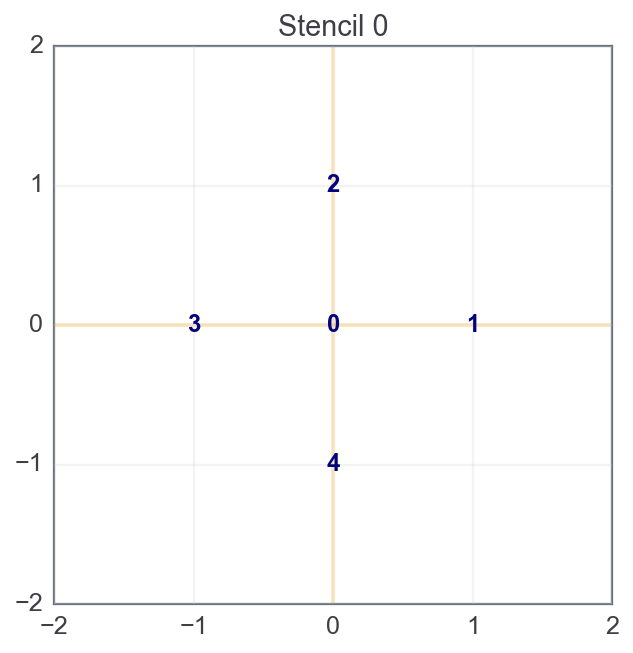

In [4]:
dico_sten = {
    'dim': 2,
    'schemes': [
        {
            'velocities': list(range(5)),
        },
    ],
}
sten = pyLBM.Stencil(dico_sten)
print(sten)
sten.visualize()

### The domain

In order to build the domain of the simulation, the dictionary should contain the space step $\dx$ and the stencils of the velocities (one for each scheme). 

We construct a domain with $N=10$ points in space. 

Domain informations
	 spatial dimension: 2
	 space step: dx= 7.812e-03



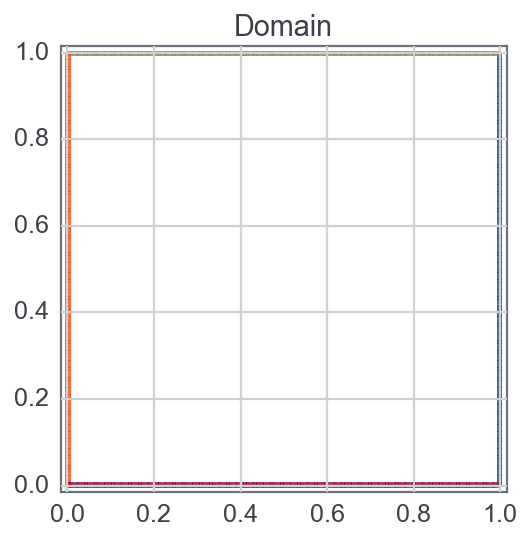

In [5]:
dico_dom = {
    'box': {
        'x': [xmin, xmax], 
        'y': [ymin, ymax], 
        'label':0,
    },
    'space_step': dx,
    'schemes':[
        {
            'velocities': list(range(5)),
        }
    ],
}
dom = pyLBM.Domain(dico_dom)
print(dom)
dom.visualize(view_bound = True, view_distance = True, view_in = False, view_out = False)

### The scheme

In pyLBM, a simulation can be performed by using several coupled schemes. In this example, a single scheme is used and defined through a list of one single dictionary. This dictionary should contain:

* 'velocities': a list of the velocities
* 'conserved_moments': a list of the conserved moments as sympy variables
* 'polynomials': a list of the polynomials that define the moments
* 'equilibrium': a list of the equilibrium value of all the moments
* 'relaxation_parameters': a list of the relaxation parameters ($0$ for the conserved moments)
* 'init': a dictionary to initialize the conserved moments

(see the documentation for more details)

The scheme velocity could be taken to $1/\dx$ and the inital value of $u$ to 

$$ u(t=0,x) = \sin(\pi x)\sin(\pi y).$$

In [6]:
# symbolic variables
u, X, Y, LA = sp.symbols('u, X, Y, LA')

dico = {
    'box':{
        'x': [xmin, xmax], 
        'y': [ymin, ymax], 
        'label':0,
    },
    'space_step': dx,
    'scheme_velocity': la,
    'schemes':[
        {
            'velocities': list(range(5)),
            'conserved_moments': u,
            'polynomials': [1, X/LA, Y/LA, (X**2+Y**2)/(2*LA**2), (X**2-Y**2)/(2*LA**2)],
            'equilibrium': [u, 0., 0., .5*u, 0.],
            'relaxation_parameters': [0., s1, s1, s2, s2],
            'init': {u: (solution, (0.,k,l))},
        }
    ],
    'boundary_conditions': {
        0: {'method': {0: pyLBM.bc.anti_bounce_back,}, 'value':None},
    },
    'parameters': {LA: la},
    'show_code': True,
}
sch = pyLBM.Scheme(dico)
print(sch)

Scheme informations
	 spatial dimension: dim=2
	 number of schemes: nscheme=1
	 number of velocities:
    Stencil.nv[0]=5
	 velocities value:
    v[0] = (0: 0, 0), (1: 1, 0), (2: 0, 1), (3: -1, 0), (4: 0, -1), 
	 polynomials:
    P[0] = 1, X/LA, Y/LA, (X**2 + Y**2)/(2*LA**2), (X**2 - Y**2)/(2*LA**2), 
	 equilibria:
    EQ[0] = u, 0.0, 0.0, 0.5*u, 0.0, 
	 relaxation parameters:
    s[0] = 0.0, 0.400000000000000, 0.400000000000000, 1.00000000000000, 1.00000000000000, 
	 moments matrices
M      = Matrix([[1, 1, 1, 1, 1], [0, 128.0/LA, 0, -128.0/LA, 0], [0, 0, 128.0/LA, 0, -128.0/LA], [0, 8192.0/LA**2, 8192.0/LA**2, 8192.0/LA**2, 8192.0/LA**2], [0, 8192.0/LA**2, -8192.0/LA**2, 8192.0/LA**2, -8192.0/LA**2]])
M^(-1) = Matrix([[1, 0, 0, -0.0001220703125*LA**2, 0], [0, 0.00390625*LA, 0, 3.0517578125e-5*LA**2, 3.0517578125e-5*LA**2], [0, 0, 0.00390625*LA, 3.0517578125e-5*LA**2, -3.0517578125e-5*LA**2], [0, -0.00390625*LA, 0, 3.0517578125e-5*LA**2, 3.0517578125e-5*LA**2], [0, 0, -0.00390625*LA, 

### The simulation

A simulation is built by defining a correct dictionary.

We combine the previous dictionaries to build a simulation. In order to impose the homogeneous Dirichlet conditions in $x=0$, $x=1$, $y=0$, and $y=1$, the dictionary should contain the key 'boundary_conditions' (we use pyLBM.bc.Anti_bounce_back function).

In [7]:
sol = pyLBM.Simulation(dico)

#!python
#cython: boundscheck=False
#cython: wraparound=False
#cython: cdivision=True
#cython: binding=True
#import cython
from libc.math cimport *


def f2m(double[:, :, ::1] f, int nx, int ny, double[:, :, ::1] m):
    cdef int ix
    cdef int iy

    for ix in range(0, nx):
        for iy in range(0, ny):
            m[ix, iy, 0] = f[ix, iy, 0] + f[ix, iy, 1] + f[ix, iy, 2] + f[ix, iy, 3] + f[ix, iy, 4]
            m[ix, iy, 1] = 1.0*f[ix, iy, 1] - 1.0*f[ix, iy, 3]
            m[ix, iy, 2] = 1.0*f[ix, iy, 2] - 1.0*f[ix, iy, 4]
            m[ix, iy, 3] = 0.5*f[ix, iy, 1] + 0.5*f[ix, iy, 2] + 0.5*f[ix, iy, 3] + 0.5*f[ix, iy, 4]
            m[ix, iy, 4] = 0.5*f[ix, iy, 1] - 0.5*f[ix, iy, 2] + 0.5*f[ix, iy, 3] - 0.5*f[ix, iy, 4]
        #end
    #end
#end
def m2f(double[:, :, ::1] m, int nx, int ny, double[:, :, ::1] f):
    cdef int ix
    cdef int iy

    for ix in range(0, nx):
        for iy in range(0, ny):
            f[ix, iy, 0] = m[ix, iy, 0] - 2.0*m[ix, iy, 3]
            f[ix

### Run a simulation

Once the simulation is initialized, one time step can be performed by using the function one_time_step.

We compute the solution of the heat equation at $t=0.1$. On the same graphic, we plot the initial condition, the exact solution and the numerical solution.

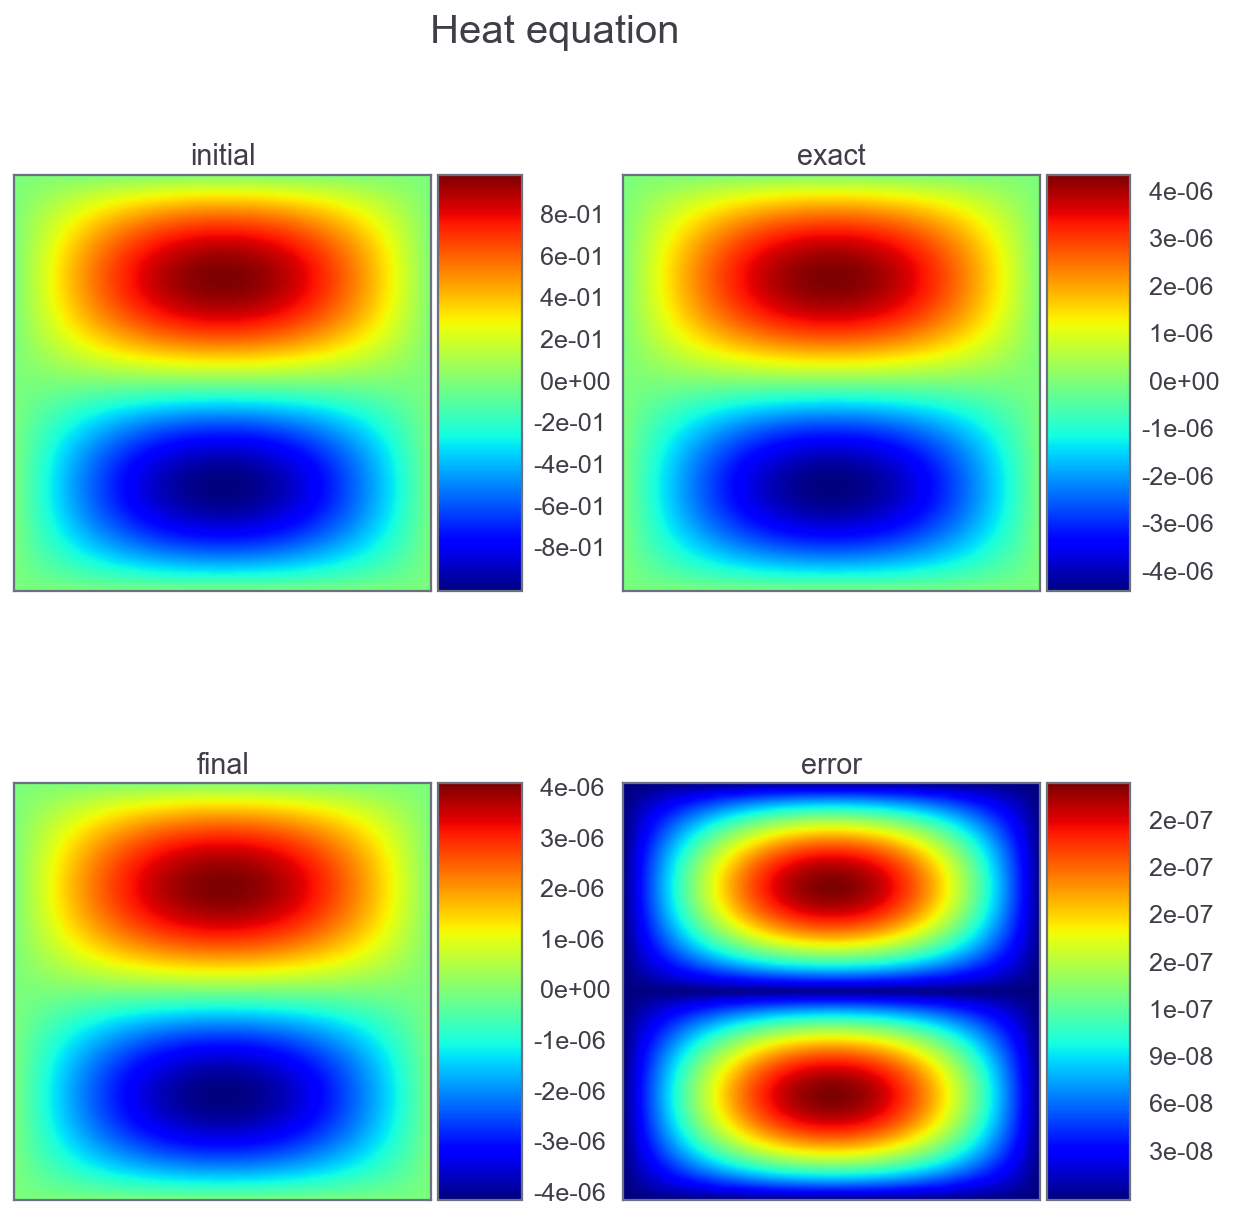

In [8]:
def plot(i, j, z, title):
    im = axarr[i,j].imshow(z)
    divider = make_axes_locatable(axarr[i, j])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, format='%6.0e')
    axarr[i, j].xaxis.set_visible(False)
    axarr[i, j].yaxis.set_visible(False)
    axarr[i, j].set_title(title)

x = sol.domain.x
y = sol.domain.y

f, axarr = plt.subplots(2, 2, figsize = (10,10))
f.suptitle('Heat equation', fontsize=20)

plot(0, 0, sol.m[u].copy(), 'initial')

while sol.t < Tf:
    sol.one_time_step()

z = sol.m[u]
ze = solution(x[:,np.newaxis], y[np.newaxis,:], sol.t, k, l)
plot(1, 0, z, 'final')
plot(0, 1, ze, 'exact')
plot(1, 1, abs(z-ze), 'error')